In [1]:
#Customer Segmentation with K-Means & RFM A

In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score

# Set Visualization Styles
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [21]:
# Load Dataset
df = pd.read_csv(r"C:\Users\rudra\Downloads\data.csv", encoding="ISO-8859-1")

# Display the first 5 rows
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [22]:
# Display dataset structure and types
print("\n Dataset Information:")
df.info()

# Check for missing values
print("\n Missing Values Per Column:")
print(df.isna().sum())


 Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB

 Missing Values Per Column:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [23]:
# Display summary statistics for numerical columns
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [6]:
import numpy as np
import pandas as pd

# Drop rows with missing CustomerID
df.dropna(subset=["CustomerID"], inplace=True)

# Convert CustomerID to integer for consistency
df["CustomerID"] = df["CustomerID"].astype(int)

# Remove transactions with negative quantities (returns and errors)
df = df[df["Quantity"] > 0]

# Display dataset summary after handling missing values
print("\n✅ Data Info After Handling Missing & Invalid Values:")
df.info()



✅ Data Info After Handling Missing & Invalid Values:
<class 'pandas.core.frame.DataFrame'>
Index: 397924 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    397924 non-null  object 
 1   StockCode    397924 non-null  object 
 2   Description  397924 non-null  object 
 3   Quantity     397924 non-null  int64  
 4   InvoiceDate  397924 non-null  object 
 5   UnitPrice    397924 non-null  float64
 6   CustomerID   397924 non-null  int64  
 7   Country      397924 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 27.3+ MB


In [7]:
# Convert InvoiceDate to datetime format
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# Create a new column: Total Transaction Value
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

# Remove duplicate rows
df.drop_duplicates(inplace=True)

# Display dataset summary after conversion
print("\n Data Info After Type Conversion & Feature Engineering:")
df.info()


 Data Info After Type Conversion & Feature Engineering:
<class 'pandas.core.frame.DataFrame'>
Index: 392732 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392732 non-null  object        
 1   StockCode    392732 non-null  object        
 2   Description  392732 non-null  object        
 3   Quantity     392732 non-null  int64         
 4   InvoiceDate  392732 non-null  datetime64[ns]
 5   UnitPrice    392732 non-null  float64       
 6   CustomerID   392732 non-null  int64         
 7   Country      392732 non-null  object        
 8   TotalPrice   392732 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 30.0+ MB


In [8]:
# Select only numeric columns for validation
numeric_cols = df.select_dtypes(include=[np.number])

# Replace infinite values with NaN only if they exist
if np.isinf(numeric_cols.to_numpy()).sum() > 0:
    print(" Warning: Infinite values detected. Replacing with NaN...")
    df[numeric_cols.columns] = df[numeric_cols.columns].replace([np.inf, -np.inf], np.nan)

# Drop any remaining NaN values
df.dropna(inplace=True)

# Display dataset summary after handling infinite & NaN values
print("\n Data Info After Handling Infinite & NaN Values:")
df.info()


 Data Info After Handling Infinite & NaN Values:
<class 'pandas.core.frame.DataFrame'>
Index: 392732 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392732 non-null  object        
 1   StockCode    392732 non-null  object        
 2   Description  392732 non-null  object        
 3   Quantity     392732 non-null  int64         
 4   InvoiceDate  392732 non-null  datetime64[ns]
 5   UnitPrice    392732 non-null  float64       
 6   CustomerID   392732 non-null  int64         
 7   Country      392732 non-null  object        
 8   TotalPrice   392732 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 30.0+ MB


In [9]:
# Convert float columns to float32 and int columns to int32 for memory optimization
for col in numeric_cols.columns:
    if df[col].dtype == "float64":
        df[col] = df[col].astype("float32")
    elif df[col].dtype == "int64":
        df[col] = df[col].astype("int32")

# Display final dataset summary
print("\n✅ Final Dataset Info After Optimization:")
df.info()


✅ Final Dataset Info After Optimization:
<class 'pandas.core.frame.DataFrame'>
Index: 392732 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392732 non-null  object        
 1   StockCode    392732 non-null  object        
 2   Description  392732 non-null  object        
 3   Quantity     392732 non-null  int32         
 4   InvoiceDate  392732 non-null  datetime64[ns]
 5   UnitPrice    392732 non-null  float32       
 6   CustomerID   392732 non-null  int32         
 7   Country      392732 non-null  object        
 8   TotalPrice   392732 non-null  float32       
dtypes: datetime64[ns](1), float32(2), int32(2), object(4)
memory usage: 24.0+ MB


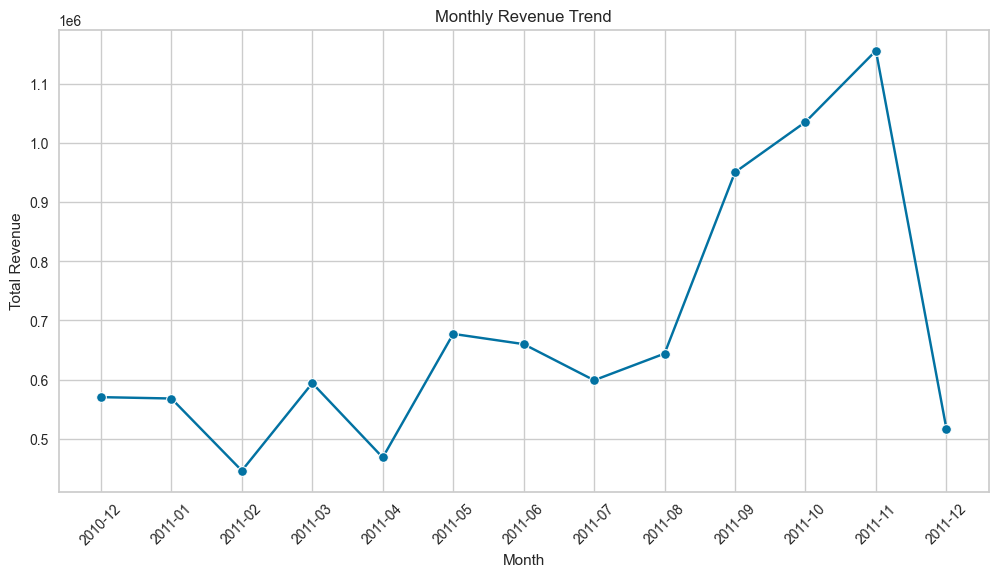

In [10]:
# Extract year-month for analysis
df["YearMonth"] = df["InvoiceDate"].dt.to_period("M")

# Aggregate revenue by month
monthly_revenue = df.groupby("YearMonth")["TotalPrice"].sum()

# Visualization: Monthly Revenue Trend
plt.figure(figsize=(12,6))
sns.lineplot(x=monthly_revenue.index.astype(str), y=monthly_revenue.values, marker="o")
plt.xticks(rotation=45)
plt.title("Monthly Revenue Trend")
plt.xlabel("Month")
plt.ylabel("Total Revenue")
plt.grid(True)
plt.show()

C:\Users\rudra\AppData\Local\Temp\ipykernel_44776\2009866050.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_revenue.index, y=country_revenue.values, palette="coolwarm")


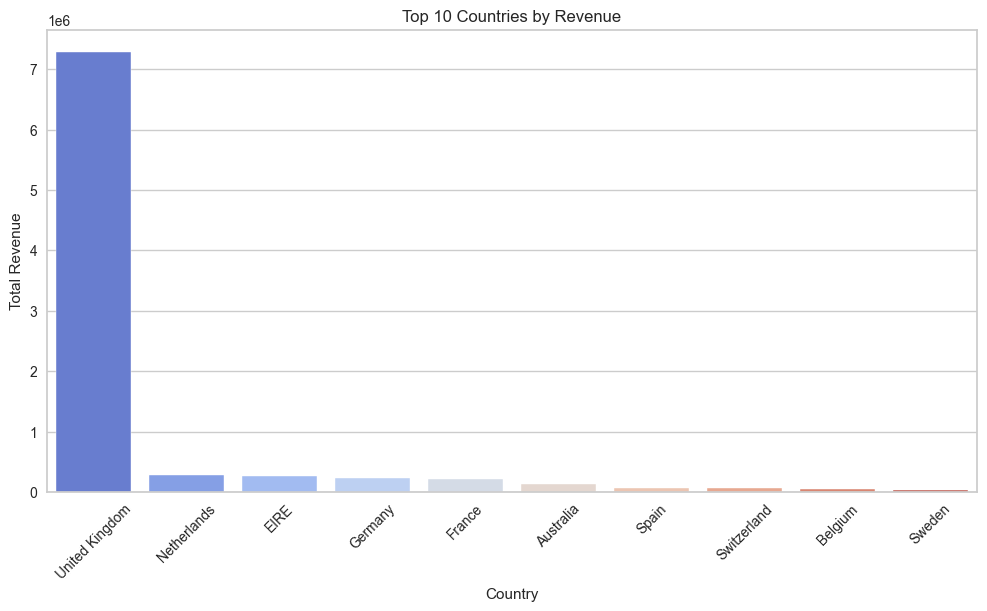

In [11]:
# Aggregate revenue by country
country_revenue = df.groupby("Country")["TotalPrice"].sum().sort_values(ascending=False).head(10)

# Visualization: Revenue by Country
plt.figure(figsize=(12,6))
sns.barplot(x=country_revenue.index, y=country_revenue.values, palette="coolwarm")
plt.xticks(rotation=45)
plt.title("Top 10 Countries by Revenue")
plt.xlabel("Country")
plt.ylabel("Total Revenue")
plt.show()


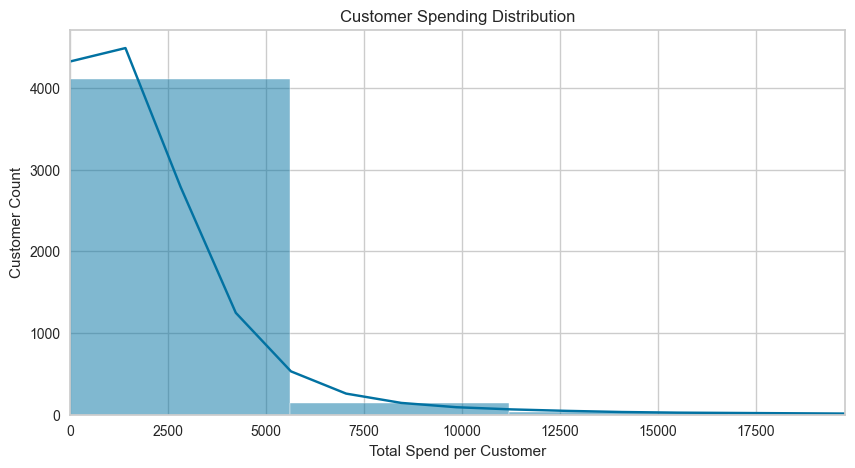

In [12]:
# Aggregate total spend per customer
customer_spend = df.groupby("CustomerID")["TotalPrice"].sum()

# Visualization: Customer Spending Distribution
plt.figure(figsize=(10,5))
sns.histplot(customer_spend, bins=50, kde=True)
plt.title("Customer Spending Distribution")
plt.xlabel("Total Spend per Customer")
plt.ylabel("Customer Count")
plt.xlim(0, customer_spend.quantile(0.99))  # Remove extreme outliers
plt.show()

In [13]:
# Define reference date (latest transaction date)
reference_date = df["InvoiceDate"].max()

# Compute Recency (Days Since Last Purchase), Frequency, and Monetary Value
rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (reference_date - x.max()).days,  # Recency
    "InvoiceNo": "nunique",  # Frequency
    "TotalPrice": "sum"  # Monetary
})

# Rename columns
rfm.columns = ["Recency", "Frequency", "Monetary"]

# Display RFM table
rfm.describe()

,Recency,Frequency,Monetary
count,4339.000000,4339.000000,4339.000000
mean,91.518322,4.271952,2048.216064
std,100.009747,7.705493,8984.248047
min,0.000000,1.000000,0.000000
25%,17.000000,1.000000,306.455002
50%,50.000000,2.000000,668.559998
75%,141.000000,5.000000,1660.315002
max,373.000000,210.000000,280206.031250


In [14]:
# Normalize the RFM values
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# Display first few rows
pd.DataFrame(rfm_scaled, columns=["Recency", "Frequency", "Monetary"]).head()

,Recency,Frequency,Monetary
0,2.334858,-0.424675,8.363977
1,-0.905199,0.354080,0.251779
2,-0.175186,-0.035297,-0.027938
3,-0.735196,-0.424675,-0.032357
4,2.174855,-0.424675,-0.190780


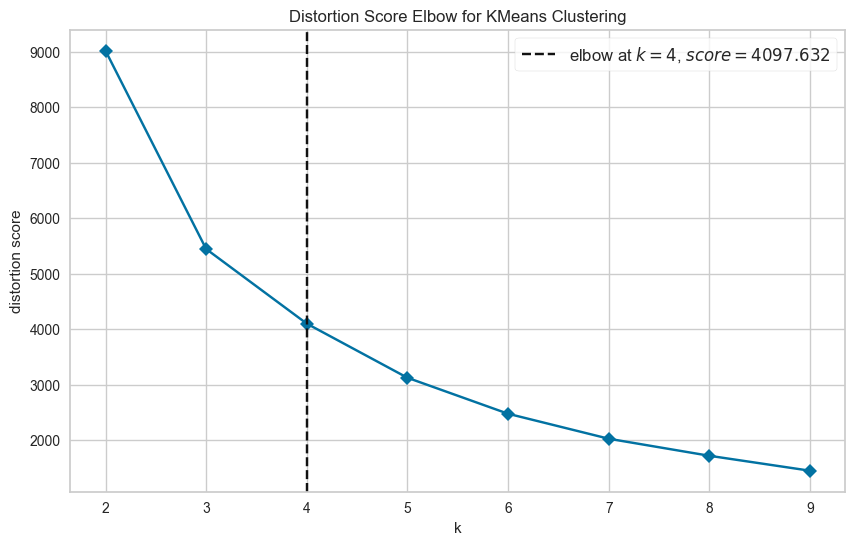

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [15]:
# Use Elbow Method to determine best k
model = KMeans(n_init=10, random_state=42)
visualizer = KElbowVisualizer(model, k=(2,10), metric='distortion', timings=False)
visualizer.fit(rfm_scaled)
visualizer.show()


In [16]:
# Apply K-Means Clustering
optimal_k = 4  

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
rfm["Cluster"] = kmeans.fit_predict(rfm_scaled)

# Reset index for CustomerID visibility
rfm = rfm.reset_index()

# Display first few rows with assigned clusters
rfm.head()

,CustomerID,Recency,Frequency,Monetary,Cluster
0,12346,325,1,77183.601562,0
1,12347,1,7,4310.000000,3
2,12348,74,4,1797.239990,3
3,12349,18,1,1757.550049,3
4,12350,309,1,334.399994,1


In [17]:
# Compute mean RFM values per cluster
rfm_avg = rfm.groupby("Cluster")[["Recency", "Frequency", "Monetary"]].mean().round(2)

# Display the average RFM values per segment
print("\n Average RFM Values Per Segment:")
print(rfm_avg)


 Average RFM Values Per Segment:
         Recency  Frequency       Monetary
Cluster                                   
0          14.67      22.05   12435.089844
1         247.56       1.55     476.329987
2           6.38      82.69  127187.960938
3          42.91       3.66    1344.280029


In [18]:
# Store customer IDs per segment
segment_dict = {}

for cluster in rfm["Cluster"].unique():
    segment_dict[f"Cluster_{cluster}"] = rfm[rfm["Cluster"] == cluster]["CustomerID"].tolist()

# Display first 10 customer IDs per segment
for cluster, customers in segment_dict.items():
    print(f"{cluster} - {len(customers)} Customers")
    print(customers[:10])
    print("...")

Cluster_0 - 211 Customers
[12346, 12431, 12437, 12471, 12474, 12540, 12569, 12583, 12621, 12678]
...
Cluster_3 - 3053 Customers
[12347, 12348, 12349, 12352, 12356, 12357, 12358, 12359, 12360, 12362]
...
Cluster_1 - 1062 Customers
[12350, 12353, 12354, 12355, 12361, 12365, 12373, 12377, 12383, 12386]
...
Cluster_2 - 13 Customers
[12415, 12748, 13089, 14156, 14646, 14911, 15311, 16029, 16446, 17450]
...


In [19]:
# Save customer segmentation results
rfm.to_csv("customer_segments.csv", index=False)

print("Customer segmentation results saved as 'customer_segments.csv'")

Customer segmentation results saved as 'customer_segments.csv'
